<a href="https://colab.research.google.com/github/patriciagarcia654/runoff-forecast-project/blob/main/RunoffPatricia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [12]:
# STEP 2: Load and Clean Functions

def load_nwm_forecasts(folder):
    all_dfs = []
    for f in os.listdir(folder):
        if f.endswith('.csv') and not f.startswith(('09520500','11266500')):
            df = pd.read_csv(os.path.join(folder, f))
            df = df[['model_output_valid_time','streamflow_value']].rename(
                columns={'model_output_valid_time':'timestamp','streamflow_value':'nwm_forecast'}
            )
            all_dfs.append(df)
    df = pd.concat(all_dfs,ignore_index=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d_%H:%M:%S')
    return df.sort_values('timestamp')

def load_usgs_observed(folder, gage_prefix, station_name):
    fn = next(x for x in os.listdir(folder) if x.startswith(gage_prefix))
    df = pd.read_csv(os.path.join(folder, fn))
    dtcol = 'DateTime' if 'DateTime' in df.columns else 'datetime'
    df['timestamp'] = pd.to_datetime(df[dtcol], errors='coerce')
    if 'USGSFlowValue' in df.columns:
        qcol = 'USGSFlowValue'
    else:
        qcol = [c for c in df.columns if '00060' in c][0]
    df['observed_runoff'] = pd.to_numeric(df[qcol], errors='coerce')
    df['USGS_GageID'] = station_name
    return df[['timestamp','observed_runoff','USGS_GageID']]


In [14]:
# STEP 3
base = '/content/drive/MyDrive/Colab-Notebooks'

nwm_station_a_folder = '/content/runoff-forecast-project/data/20380357/'
nwm_station_b_folder = '/content/runoff-forecast-project/data/21609641/'

nwm_a = load_nwm_forecasts(nwm_station_a_folder)
nwm_b = load_nwm_forecasts(nwm_station_b_folder)

obs_a = load_usgs_observed(f'{base}/20380357/','09520500','A')
obs_b = load_usgs_observed(f'{base}/21609641/','11266500','B')


In [15]:
# STEP 4

def merge_and_filter(nwm, obs):
    try:
        nwm['timestamp'] = nwm['timestamp'].dt.tz_localize(None)
    except (AttributeError, TypeError):
        pass
    try:
        obs['timestamp'] = obs['timestamp'].dt.tz_localize(None)
    except (AttributeError, TypeError):
        pass

    df = pd.merge(nwm, obs, on='timestamp', how='inner')

    df = df.dropna(subset=['nwm_forecast','observed_runoff'])
    df = df[df['timestamp'].dt.minute == 0].reset_index(drop=True)
    return df



merged_a = merge_and_filter(nwm_a, obs_a)
merged_b = merge_and_filter(nwm_b, obs_b)


In [16]:
# STEP 5

def add_multi_error_targets(df, n_leads=18):
    for lead in range(1, n_leads+1):
        df[f'error_t+{lead}'] = (
            df['observed_runoff'].shift(-lead) - df['nwm_forecast'].shift(-lead)
        )
    return df.dropna().reset_index(drop=True)

merged_a = add_multi_error_targets(merged_a, n_leads=18)
merged_b = add_multi_error_targets(merged_b, n_leads=18)


In [17]:
# STEP 6:

def split_train_test(df):
    train = df[(df['timestamp']>='2021-04-01') & (df['timestamp']<='2022-09-30')].reset_index(drop=True)
    test  = df[(df['timestamp']>='2022-10-01') & (df['timestamp']<='2023-04-30')].reset_index(drop=True)
    return train, test

train_a, test_a = split_train_test(merged_a)
train_b, test_b = split_train_test(merged_b)


In [18]:
# STEP 7:

def create_multi_step_sequences(df, input_col='nwm_forecast',
                                target_prefix='error_t+',
                                seq_len=24, n_leads=18):
    X, Y = [], []
    for i in range(len(df) - seq_len - n_leads + 1):
        seq_x = df[input_col].iloc[i:i+seq_len].values
        seq_y = [ df[f'{target_prefix}{lead}'].iloc[i+seq_len+lead-1]
                  for lead in range(1, n_leads+1) ]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

# build train sequences
X_train_a, Y_train_a = create_multi_step_sequences(train_a, seq_len=24, n_leads=18)

X_train_a = X_train_a.reshape((-1, X_train_a.shape[1], 1))
print("X_train_a:", X_train_a.shape, "Y_train_a:", Y_train_a.shape)


X_train_a: (233624, 24, 1) Y_train_a: (233624, 18)


In [19]:
# STEP 8:

scaler_forecast = StandardScaler()

flat_forecasts = train_a['nwm_forecast'].values.reshape(-1,1)
scaler_forecast.fit(flat_forecasts)

ns, sl, _ = X_train_a.shape
X_train_scale = scaler_forecast.transform(X_train_a.reshape(-1,1)).reshape(ns,sl,1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 2105.8796 - val_loss: 1197.9275
Epoch 2/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 889.0903 - val_loss: 1050.3688
Epoch 3/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 739.3201 - val_loss: 1024.8856
Epoch 4/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 703.6248 - val_loss: 1023.6173
Epoch 5/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 680.4203 - val_loss: 1026.6646
Epoch 6/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 658.0341 - val_loss: 1021.3843
Epoch 7/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 653.5256 - val_loss: 1021.2344
Epoch 8/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 641.9538 - val_loss: 1023.4028
Epoch 9/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 629.5461 - val_loss: 1022.6329
Epoch 10/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 629.2125 - val_loss: 1024.3951
Epoch 11/50
2921/2921 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - 

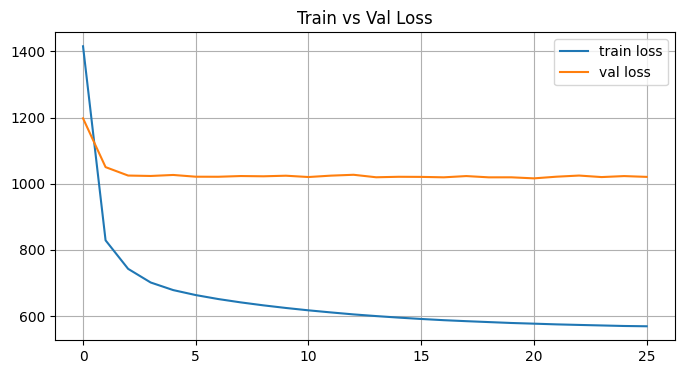

In [20]:
# STEP 9:
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(24,1)),
    Dense(18)
])
model.compile(optimizer=Adam(clipnorm=1.0), loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scale, Y_train_a,
    epochs=50, batch_size=64,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(), plt.title("Train vs Val Loss"), plt.grid(); plt.show()


In [21]:
# STEP 10

X_test_a, Y_test_a = create_multi_step_sequences(test_a, seq_len=24, n_leads=18)
X_test_a = X_test_a.reshape((-1,24,1))
X_test_scale = scaler_forecast.transform(X_test_a.reshape(-1,1)).reshape(-1,24,1)

Y_pred_a = model.predict(X_test_scale, verbose=0)


In [22]:
# STEP 11

metrics = {'lead':[], 'RMSE':[], 'R2':[], 'PBIAS':[], 'NSE':[]}
for k in range(1,19):
    orig = test_a['nwm_forecast'].shift(-k).iloc[24-1 : 24-1+Y_pred_a.shape[0]].values
    obs  = test_a['observed_runoff'].shift(-k).iloc[24-1 : 24-1+Y_pred_a.shape[0]].values
    pred_err = Y_pred_a[:, k-1].flatten()
    corr = orig + pred_err

    rmse = np.sqrt(mean_squared_error(obs, corr))
    r2   = r2_score(obs, corr)
    pbias= 100.0 * np.sum(obs-corr)/np.sum(obs)
    nse  = 1 - np.sum((obs-corr)**2)/np.sum((obs-np.mean(obs))**2)

    metrics['lead'].append(k)
    metrics['RMSE'].append(rmse)
    metrics['R2'].append(r2)
    metrics['PBIAS'].append(pbias)
    metrics['NSE'].append(nse)

metrics_df = pd.DataFrame(metrics).set_index('lead')
metrics_df


,RMSE,R2,PBIAS,NSE
lead,,,,
1,28.920136,-28177.917046,2.186246,-28177.917046
2,28.993710,-28321.421345,56.403633,-28321.421345
3,29.067009,-28464.753124,134.764656,-28464.753124
4,29.152231,-28631.860542,3.804721,-28631.860542
5,29.229275,-28783.348650,72.653040,-28783.348650
6,29.338754,-28999.322854,117.317531,-28999.322854
7,29.428496,-29176.951195,92.905075,-29176.951195
8,29.449405,-29218.372374,-77.600308,-29218.372374
9,29.475239,-29269.602617,71.458540,-29269.602617


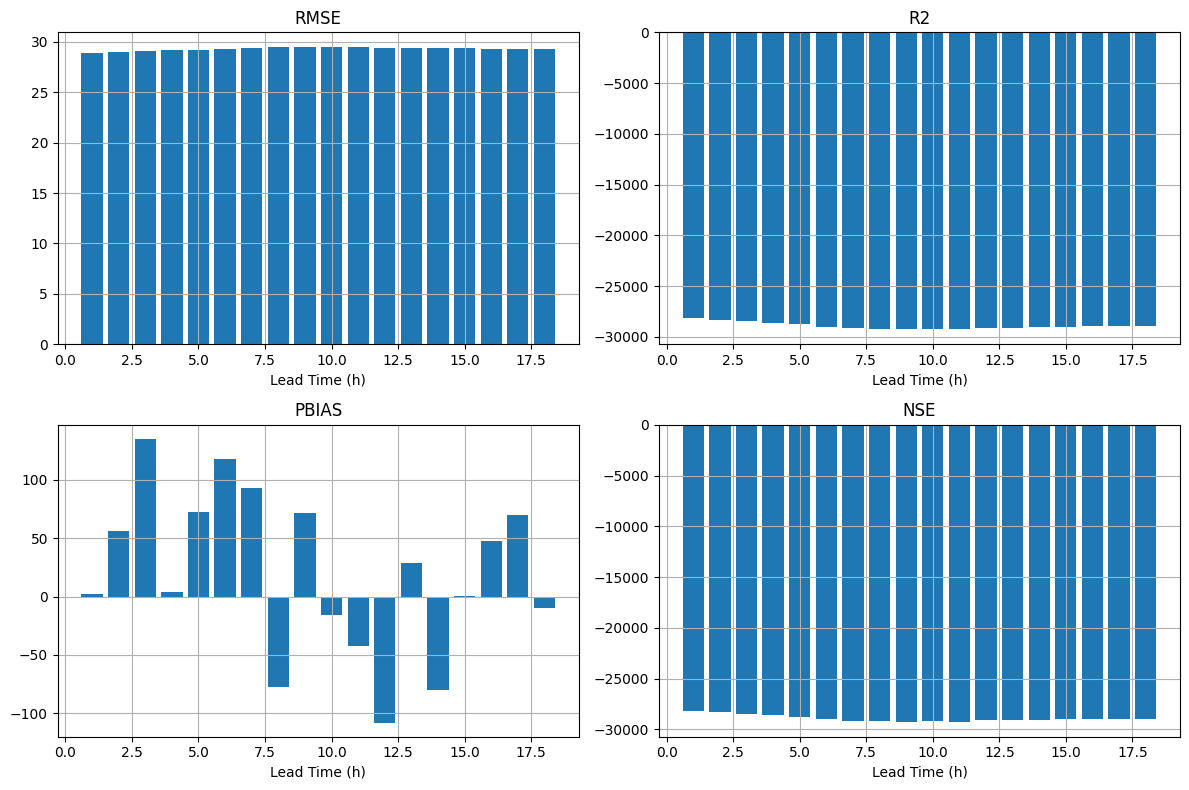

In [23]:
# STEP 12:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, (mname, series) in zip(axes.flatten(), metrics_df.items()):
    ax.bar(metrics_df.index, series, color='C0')
    ax.set_title(mname)
    ax.set_xlabel('Lead Time (h)')
    ax.grid(True)

plt.tight_layout()
plt.show()



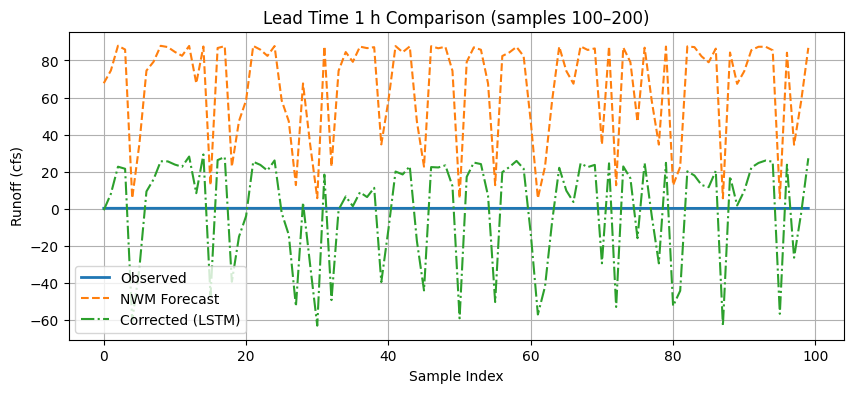

In [25]:
# STEP 13


import matplotlib.pyplot as plt

lt = 1
idx0 = 100
length = 100

start = 24 - 1
N = Y_pred_a.shape[0]

obs_arr = test_a['observed_runoff'].iloc[start : start + N].values
nwm_arr = test_a['nwm_forecast'].iloc[start : start + N].values
corr_arr = nwm_arr + Y_pred_a[:, lt-1]

obs_seq  = obs_arr[idx0 : idx0 + length]
nwm_seq  = nwm_arr[idx0 : idx0 + length]
corr_seq = corr_arr[idx0 : idx0 + length]

plt.figure(figsize=(10,4))
plt.plot(obs_seq,  label='Observed', linewidth=2)
plt.plot(nwm_seq,  label='NWM Forecast', linestyle='--')
plt.plot(corr_seq, label='Corrected (LSTM)', linestyle='-.')
plt.title(f'Lead Time {lt} h Comparison (samples {idx0}–{idx0+length})')
plt.xlabel('Sample Index')
plt.ylabel('Runoff (cfs)')
plt.legend()
plt.grid()
plt.show()


